#Credit card Fraud Detection Model

###How to deal with unbalanced data? A comparison between Undersampling and Oversampling with SMOTE

The following notebook is about the application of undersampling and oversampling techniques on a credit card fraud dataset to deal with heavy unbalanced datasets.
The project is structured as follows:

Data loading.
Data cleaning:
Duplicated data check.
Box Cox tranformation of skewed features.
PCA for dimensionality reduction.
Unbalanced problem: Undersampling and Oversampling with SMOTE.
Neural networks by Keras, modeling and training.
Results comparison: ROC, Confusion Matrix, Precision, Recall.

#Data loading

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Import the require library

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score, accuracy_score, auc

from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from tensorflow import keras
from tensorflow.keras import layers

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
seed=42

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

##Custom function

Make a custom function

In [ ]:
def num_plot(df, col, title, symb):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,5),gridspec_kw={"height_ratios": (.2, .8)})
    ax[0].set_title(title,fontsize=18)
    sns.boxplot(x=col, data=df, ax=ax[0])
    ax[0].set(yticks=[])
    sns.histplot(x=col, data=df, ax=ax[1])
    ax[1].set_xlabel(col, fontsize=16)
    plt.axvline(df[col].mean(), color='darkgreen', linewidth=2.2, label='mean=' + str(np.round(df[col].mean(),1)) + symb)
    plt.axvline(df[col].median(), color='red', linewidth=2.2, label='median='+ str(np.round(df[col].median(),1)) + symb)
    plt.axvline(df[col].mode()[0], color='purple', linewidth=2.2, label='mode='+ str(np.round(df[col].mode()[0],1)) + symb)
    plt.legend(bbox_to_anchor=(1, 1.03), ncol=1, fontsize=17, fancybox=True, shadow=True, frameon=True)
    plt.tight_layout()
    plt.show()

Import the dataset for creditcard

In [ ]:
df = pd.read_csv('/creditcard.csv', skipinitialspace=True)

Show the 10 head rows.

In [ ]:
df.head(10)         #Inspecting the first 5 rows

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,0.686133,-0.076127,-1.222127,-0.358222,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,0.074355,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,1.017614,0.836390,1.006844,-0.443523,0.150219,0.739453,-0.540980,0.476677,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


Show the 10 tail rows.

In [ ]:
df.tail(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amount_bc
284797,-0.241923,0.712247,0.399806,-0.463406,0.244531,-1.343668,0.929369,-0.206210,0.106234,-0.284708,-0.612982,-0.066655,-0.732987,0.237948,-0.293959,-0.245496,-0.174846,-0.891169,-0.290491,-0.139512,-0.228876,-0.514376,0.279598,0.371441,-0.559238,0.113144,0.131507,0.081265,0,1.840805
284798,0.219529,0.881246,-0.635891,0.960928,-0.152971,-1.014307,0.427126,0.121340,-0.285670,-0.111640,-1.109232,-0.453235,-1.046946,1.122674,1.243518,-1.431897,0.939328,-0.002373,2.894952,0.006666,0.099936,0.337120,0.251791,0.057688,-1.508368,0.144023,0.181205,0.215243,0,3.134170
284799,-1.775135,-0.004235,1.189786,0.331096,1.196063,5.519980,-1.518185,2.080825,1.159498,-0.594242,-1.264072,0.453596,-0.243142,-0.858719,-0.766554,-0.644646,0.447184,0.388721,0.792135,0.348176,0.103302,0.654850,-0.348929,0.745323,0.704545,-0.127579,0.454379,0.130308,0,4.233995
284800,2.039560,-0.175233,-1.196825,0.234580,-0.008713,-0.726571,0.017050,-0.118228,0.435402,0.267772,0.523316,0.559047,-0.834660,0.626211,-0.541494,0.225361,-0.605252,-0.163049,0.561695,-0.256922,-0.268048,-0.717211,0.297930,-0.359769,-0.315610,0.201114,-0.080826,-0.075071,0,1.288570
284801,0.120316,0.931005,-0.546012,-0.745097,1.130314,-0.235973,0.812722,0.115093,-0.204064,-0.657422,0.644837,0.190916,-0.546329,-0.731707,-0.808036,0.599628,0.070441,0.373110,0.128904,0.000676,-0.314205,-0.808520,0.050343,0.102800,-0.435870,0.124079,0.217940,0.068803,0,1.291225
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0,0.568214
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0,3.161722
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0,4.083501
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0,2.349615
284806,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,-0.915427,-1.040458,-0.031513,-0.188093,-0.084316,0.041333,-0.302620,-0.660377,0.167430,-0.256117,0.382948,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,0,5.145099


To check how many rows and column are there.

In [ ]:
df.shape

(284807, 31)

In [ ]:
df.describe

<bound method NDFrame.describe of             Time         V1         V2  ...       V28  Amount  Class
0            0.0  -1.359807  -0.072781  ... -0.021053  149.62      0
1            0.0   1.191857   0.266151  ...  0.014724    2.69      0
2            1.0  -1.358354  -1.340163  ... -0.059752  378.66      0
3            1.0  -0.966272  -0.185226  ...  0.061458  123.50      0
4            2.0  -1.158233   0.877737  ...  0.215153   69.99      0
...          ...        ...        ...  ...       ...     ...    ...
284802  172786.0 -11.881118  10.071785  ...  0.823731    0.77      0
284803  172787.0  -0.732789  -0.055080  ... -0.053527   24.79      0
284804  172788.0   1.919565  -0.301254  ... -0.026561   67.88      0
284805  172788.0  -0.240440   0.530483  ...  0.104533   10.00      0
284806  172792.0  -0.533413  -0.189733  ...  0.013649  217.00      0

[284807 rows x 31 columns]>

##Check for Duplicates

In [ ]:
df[df.duplicated()]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
33,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,-0.484688,0.872490,0.851636,-0.571745,0.100974,-1.519772,-0.284376,-0.310524,-0.404248,-0.823374,-0.290348,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
35,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,-0.482474,0.871800,0.853447,-0.571822,0.102252,-1.519991,-0.285912,-0.309633,-0.403902,-0.823743,-0.283264,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
113,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,-0.243289,0.578063,0.674730,-0.534231,0.446601,1.122885,-1.768001,1.241157,-2.449500,-1.747255,-0.335520,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
114,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,-0.243289,0.578063,0.674730,-0.534231,0.446601,1.122885,-1.768001,1.241157,-2.449500,-1.747255,-0.335520,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
115,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,-0.243289,0.578063,0.674730,-0.534231,0.446601,1.122885,-1.768001,1.241157,-2.449500,-1.747255,-0.335520,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282987,171288.0,1.912550,-0.455240,-1.750654,0.454324,2.089130,4.160019,-0.881302,1.081750,1.022928,0.005356,-0.541998,0.745036,-0.375165,-0.068227,-0.795939,-0.497901,-0.134224,-1.004958,0.086074,-0.207620,-0.524067,-1.337510,0.473943,0.616683,-0.283548,-1.084843,0.073133,-0.036020,11.99,0
283483,171627.0,-1.464380,1.368119,0.815992,-0.601282,-0.689115,-0.487154,-0.303778,0.884953,0.054065,-0.828015,-1.192581,0.944989,1.372532,-0.036493,-0.208747,0.320086,-0.204910,-0.024821,-0.468859,0.031950,0.287217,0.947825,-0.218773,0.082926,0.044127,0.639270,0.213565,0.119251,6.82,0
283485,171627.0,-1.457978,1.378203,0.811515,-0.603760,-0.711883,-0.471672,-0.282535,0.880654,0.052808,-0.830603,-1.191774,0.942870,1.372621,-0.037988,-0.208490,0.321883,-0.205951,-0.025225,-0.468427,0.023667,0.284205,0.949659,-0.216949,0.083250,0.044944,0.639933,0.219432,0.116772,11.93,0
284191,172233.0,-2.667936,3.160505,-3.355984,1.007845,-0.377397,-0.109730,-0.667233,2.309700,-1.639306,-1.449823,-0.508930,0.600035,-0.627313,1.017499,-0.887384,0.420096,1.856497,1.315099,1.096112,-0.821707,0.391483,0.266536,-0.079853,-0.096395,0.086719,-0.451128,-1.183743,-0.222200,55.66,0


Check the number of Duplicates in 

In [ ]:
df[df.duplicated()].shape

(1081, 31)

In [ ]:
#df = df[~df.duplicated()]

In [ ]:
df.drop('Time', axis=1, inplace=True)

In [ ]:
df[df.duplicated()]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
33,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,-0.484688,0.872490,0.851636,-0.571745,0.100974,-1.519772,-0.284376,-0.310524,-0.404248,-0.823374,-0.290348,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
35,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,-0.482474,0.871800,0.853447,-0.571822,0.102252,-1.519991,-0.285912,-0.309633,-0.403902,-0.823743,-0.283264,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
113,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,-0.243289,0.578063,0.674730,-0.534231,0.446601,1.122885,-1.768001,1.241157,-2.449500,-1.747255,-0.335520,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
114,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,-0.243289,0.578063,0.674730,-0.534231,0.446601,1.122885,-1.768001,1.241157,-2.449500,-1.747255,-0.335520,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
115,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,-0.243289,0.578063,0.674730,-0.534231,0.446601,1.122885,-1.768001,1.241157,-2.449500,-1.747255,-0.335520,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284708,2.018105,0.073226,-1.615154,0.351058,0.333905,-0.676284,0.050474,-0.071028,0.302728,-0.193920,1.206863,0.611617,-0.589935,-0.529698,-0.450015,0.483411,0.321520,0.192470,0.275352,-0.184898,-0.306646,-0.841768,0.356773,0.655112,-0.331463,0.144352,-0.069820,-0.039845,1.98,0
284751,2.050734,-0.364010,-2.542843,-0.729357,2.388455,3.318015,-0.479138,0.791559,0.403374,0.093232,0.004391,0.390166,-0.212555,0.495544,0.472633,-0.171595,-0.368261,-0.976572,0.022869,-0.154978,-0.293363,-0.834802,0.381740,0.698179,-0.264798,0.219275,-0.052131,-0.066940,0.89,0
284775,1.955547,-0.724606,-1.706511,-0.611145,1.710907,3.914215,-1.248690,1.054133,1.314064,-0.150553,-0.222844,0.496839,-0.050358,0.001067,0.894690,0.001418,-0.583473,0.075802,-0.359344,-0.137290,0.193605,0.690196,0.155951,0.726775,-0.061219,-0.192666,0.060347,-0.042323,12.99,0
284785,0.032887,0.545338,-1.185844,-1.729828,2.932315,3.401529,0.337434,0.925377,-0.165663,-0.386953,-0.199626,0.032017,-0.374731,0.354051,0.041228,-0.154750,-0.482455,-0.842462,-0.206385,0.022677,-0.266113,-0.716336,0.108519,0.688519,-0.460220,0.161939,0.265368,0.090245,1.79,0


In [ ]:
df[df.duplicated()]['Class'].value_counts()

0    9125
1      19
Name: Class, dtype: int64

In [ ]:
df = df[~df.duplicated()]

In [ ]:
df.shape

(275663, 30)

Column Data Analysis

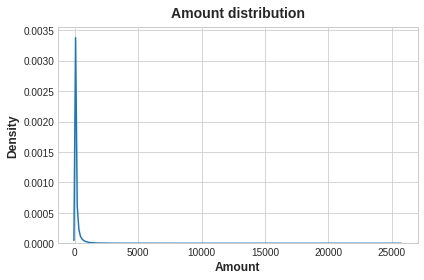

In [ ]:
sns.kdeplot(x='Amount', data=df)
plt.title('Amount distribution')
plt.show()

In [ ]:
df['Amount'].skew()

16.841622118790013

#Indeed the value of skewness is greater than 5.0,which can be consider as the threshold value of skewness

In [ ]:
df['Amount_bc'] = boxcox1p(df['Amount'], boxcox_normmax(df['Amount'] + 1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


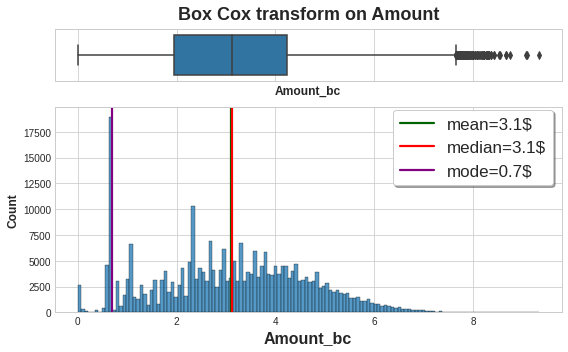

In [ ]:
num_plot(df,'Amount_bc', 'Box Cox transform on Amount','$')

In [ ]:
df['Amount_log'] = np.log(1 + df['Amount'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


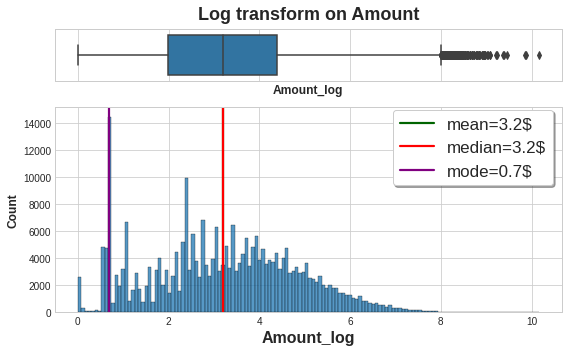

In [ ]:
num_plot(df,'Amount_log', 'Log transform on Amount','$')

The distriibutions look indeed very similar. We can choose one over the other without important differences. For example, we will chose the box-cox transformation.

In [ ]:
df.drop(['Amount','Amount_log'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


##Fraud Column analysis

The main problem with this type of datasets is target class balance, which will be covered in the following section

AttributeError: ignored

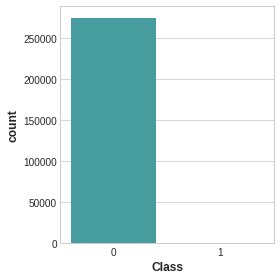

In [ ]:
perc_1 = len(df[df['Class']==1])/len(df)
perc_0 = len(df[df['Class']==0])/len(df)

labels=['No','Yes']

plt.figure(figsize=(4,4))
ax = sns.countplot(x='Class', data=df, palette='mako_r')
ax.bar_label(ax.containers[0])
plt.title('Target variable count')
plt.yticks([])
plt.figtext(.7, .7, "Fraud?\nYes:{:.3f}%\nNo:{:.3f}%".format(perc_1,perc_0), bbox ={'facecolor':'white','alpha':0.3, 'pad':5}, fontsize=13)
plt.xticks(df['Class'].value_counts().index, labels)
plt.show()

In [ ]:
X = df.drop("Class",axis=1)
y = df.Class

##Dimension Reduction Proficiency

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(X_scaled);

In [ ]:
cum_sum = np.cumsum(pca.explained_variance_ratio_)*100
comp= [n for n in range(len(cum_sum))]

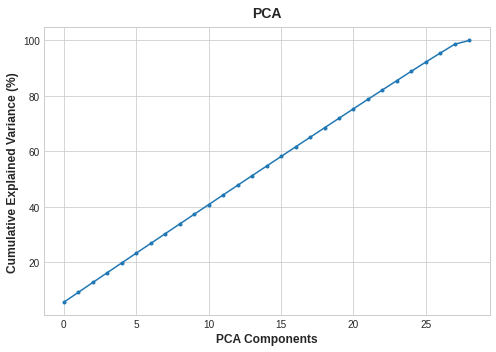

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(comp, cum_sum, marker='.')
plt.xlabel('PCA Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('PCA')
plt.show()

It looks like just one feature 'could' be removed and allow the model to still have 99% of the explainability. Usually we can keep most of the explainability removing more features, however in this dataset the features appears to be already transformed by PCA and so we could potentially just remove 1 feature.
For this reason we won't drop any features and keep the original 28 columns in the X variable.

###Unbalanced Case

First, we will train a Neural Network with the unbalanced dataset and check the performance.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=seed)

In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed)

In [ ]:
model = keras.Sequential([
    layers.Dense(80, activation='relu', input_shape=(X_train.shape[-1],)),
    layers.Dropout(0.5),
    layers.Dense(50, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
])

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['Recall'])

EPOCHS = 200
BATCH_SIZE = 1000

early_stopping = keras.callbacks.EarlyStopping(
    patience=15,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    verbose=0
)

In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = y_pred_prob.round()

In [ ]:
print(classification_report(y_test, y_pred.round(), target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       1.00      1.00      1.00     55038
         Yes       0.85      0.66      0.75        95

    accuracy                           1.00     55133
   macro avg       0.93      0.83      0.87     55133
weighted avg       1.00      1.00      1.00     55133



We can see a quite different situation in terms of scores between the 'Yes' and 'No' class: F1 score is 100% for class 'No', and 'just' 0.77 for class 'Yes.
Overall, the Neural Network did not perform too badly even if the dataset is unbalanced.

In the following, two different techniques will be used to deal with class unbalance: undersampling and oversampling.
This is a very important step: we can only apply resampling techniques (undersampling, oversampling...) on the training set! I saw on several notebooks that some people apply resampling on the overall dataset and then train test split, but this is wrong. For example, in the case of Oversampling, if we oversample frst the dataset and then split into train and test sets, it is likely that same rows will be present both in train and test sets, compromising the generalization of the algorithm.
In case of undersampling, if we undersample first and then train-test split, it means that the test set will be balanced, which would not be the case considering the problem at hand (unbalanced dataset), and would result in optimistic predictions. That is way it is importatnt to keep the test set unbalanced and apply resampling only on the training set.

Class balance by Undersampling
When undersampling, we aim to remove a number of the rows of the majority class (rows where class=0) in order to match the number of rows of the minority class (rows where class=1).

In [ ]:
y_train.value_counts()

0    176122
1       302
Name: Class, dtype: int64

This means that we will remove 176122 - 302 = 175820 rows.

In [ ]:
rus = RandomUnderSampler(random_state=seed)

In [ ]:
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)

In [ ]:
y_train_us.value_counts()

1    302
0    302
Name: Class, dtype: int64

Moreover, we further split the training set into a new train and validation dataset. This is done to monitor a metric ( accuracy or recall for example) on the validation set and so prevent overfitting.

In [ ]:
X_train_us, X_val_us, y_train_us, y_val_us = train_test_split(X_train_us, y_train_us, test_size=0.2, random_state = seed)

Neural net 1 (Undersampling)
The most important metric for this credit card fraud application is recall, since we want few false negatives as possibile: false negatives translate to 'allowed fraudolent transaction', which represent the worst case. On the other hand, false positives are 'not fraudolent' transaction flagged as fraudolent: this is what happen often also in real life, and it does not represent the worst case.

In [ ]:
model = keras.Sequential([
    layers.Dense(50, activation='relu', input_shape=(X_train.shape[-1],)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
])

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['Recall']) #choose recall as the metric


EPOCHS = 200

#setup earlystopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    patience=15,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train_us, y_train_us,
    validation_data=(X_val_us, y_val_us),
    epochs=EPOCHS,
    callbacks=[early_stopping],
    verbose=0
)

Neural net 1 prediction (Undersampling)
In particular, the output of a ANN is a probability (a number between 0 and 1), so by applying the 'round' method we can obtain either 0 or 1 starting by the probability.

In [ ]:
y_pred_prob_us = model.predict(X_test)
y_pred_us = y_pred_prob_us.round()

In [ ]:
print(classification_report(y_test, y_pred_us, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       1.00      0.98      0.99     55038
         Yes       0.06      0.89      0.11        95

    accuracy                           0.98     55133
   macro avg       0.53      0.94      0.55     55133
weighted avg       1.00      0.98      0.99     55133



We can see a very low value of precision (0.07) and quite high recall (0.88). This may be caused by the very few values of data used during the training: just 664 samples. This means that the model predicts lots of false positives fraducolent transactions, and few false negative fradudolent transactions (which is good). Overall, the F1 score is too low ( just 13% for class = 1 ).
By using such an algorithm, lots the users would see their non fraudolent transactions labeled as fraudolent.

Class balance by oversampling with SMOTE
Now, oversampling will be performed on the dataset.

In [ ]:
y_train.value_counts()

0    176122
1       302
Name: Class, dtype: int64

This means that we will add 176122 - 302 = 175820 rows with 'Class' = 1, which is indeed a large number of duplicates that will be added.

In [ ]:
smote = SMOTE(random_state=seed)

X_train_os, y_train_os = smote.fit_resample(X_train, y_train)

y_train_os.value_counts()

1    176122
0    176122
Name: Class, dtype: int64

The dataset now is balanced.

In [ ]:
X_train_os, X_val_os, y_train_os, y_val_os = train_test_split(X_train_os, y_train_os, stratify=y_train_os, test_size=0.2, random_state = seed)

Neural net 2 (Oversampling)

In [ ]:
model = keras.Sequential([
    layers.Dense(60, activation='relu', input_shape=(X_train.shape[-1],)),
    layers.Dropout(0.5),
    layers.Dense(30, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
])

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['Recall'])

EPOCHS = 200
BATCH_SIZE = 1000 #We need to include a batch size now since there are lots of data in the training set

early_stopping = keras.callbacks.EarlyStopping(
    patience=15,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val_os, y_val_os),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    verbose=0
)

Neural net 2 prediction (Oversampling)

In [ ]:
y_pred_prob_os = model.predict(X_test)
y_pred_os = y_pred_prob_os.round()

In [ ]:
print(classification_report(y_test, y_pred_os.round(), target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       1.00      1.00      1.00     55038
         Yes       0.86      0.78      0.82        95

    accuracy                           1.00     55133
   macro avg       0.93      0.89      0.91     55133
weighted avg       1.00      1.00      1.00     55133



We can see a higher F1 score (82%) in this case compared to the unbalanced (F1=77%) and undersampling case (F1=11%).
This means that oversampling with SMOTE improved the neural network overall performance.

Class balance by SMOTE + ENN
Finally, a mix between undersampling and oversampling called SMOTE + ENN will be implemented.

In [ ]:
rs = SMOTEENN(random_state=seed)

X_train_rs, y_train_rs = smote.fit_resample(X_train, y_train)

y_train_rs.value_counts()

1    176122
0    176122
Name: Class, dtype: int64

Now the number of samples per each class is 176122, compared to the original sizes of the majority class of 275190 and minority class of 473.
This means that the majority class has been undersampled and the minority class has been oversampled.

In [ ]:
X_train_rs, X_val_rs, y_train_rs, y_val_rs = train_test_split(X_train_rs, y_train_rs, stratify=y_train_rs, test_size=0.2, random_state = seed)

###Neural net(3) SMOKEENN

In [ ]:
model = keras.Sequential([
    layers.Dense(60, activation='relu', input_shape=(X_train.shape[-1],)),
    layers.Dropout(0.5),
    layers.Dense(30, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid'),
])

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['Recall'])

EPOCHS = 200
BATCH_SIZE = 800 #We need to include a batch size now since there are lots of data in the training set

early_stopping = keras.callbacks.EarlyStopping(
    patience=15,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train_rs, y_train_rs,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    verbose=0
)

###Neural net (3) Prediction 

In [ ]:
y_pred_prob_rs = model.predict(X_test)
y_pred_rs = y_pred_prob_rs.round()

In [ ]:
print(classification_report(y_test, y_pred_rs.round(), target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       1.00      1.00      1.00     55038
         Yes       0.44      0.81      0.57        95

    accuracy                           1.00     55133
   macro avg       0.72      0.90      0.78     55133
weighted avg       1.00      1.00      1.00     55133



In this the f1 score is 0.57 which is lower than unbalance and 


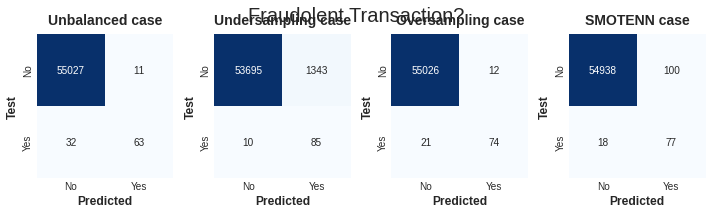

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(10,3))
labels=['No','Yes']

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False,ax=ax[0])
plt.suptitle('Fraudolent Transaction?', fontsize=20)
ax[0].set_title('Unbalanced case')
ax[0].set_yticklabels(labels);
ax[0].set_xticklabels(labels);
ax[0].set_ylabel('Test')
ax[0].set_xlabel('Predicted')

sns.heatmap(confusion_matrix(y_test, y_pred_us), annot=True, cmap="Blues", fmt='g', cbar=False,ax=ax[1])
plt.suptitle('Fraudolent Transaction?', fontsize=20)
ax[1].set_title('Undersampling case')
ax[1].set_yticklabels(labels);
ax[1].set_xticklabels(labels);
ax[1].set_ylabel('Test')
ax[1].set_xlabel('Predicted')


sns.heatmap(confusion_matrix(y_test, y_pred_os), annot=True, cmap="Blues", fmt='g', cbar=False, ax=ax[2])
ax[2].set_title('Oversampling case')
ax[2].set_xticklabels(labels);
ax[2].set_yticklabels(labels);
ax[2].set_ylabel('Test')
ax[2].set_xlabel('Predicted')
plt.tight_layout()

sns.heatmap(confusion_matrix(y_test, y_pred_rs), annot=True, cmap="Blues", fmt='g', cbar=False, ax=ax[3])
ax[3].set_title('SMOTENN case')
ax[3].set_xticklabels(labels);
ax[3].set_yticklabels(labels);
ax[3].set_ylabel('Test')
ax[3].set_xlabel('Predicted')
plt.tight_layout()


plt.show()


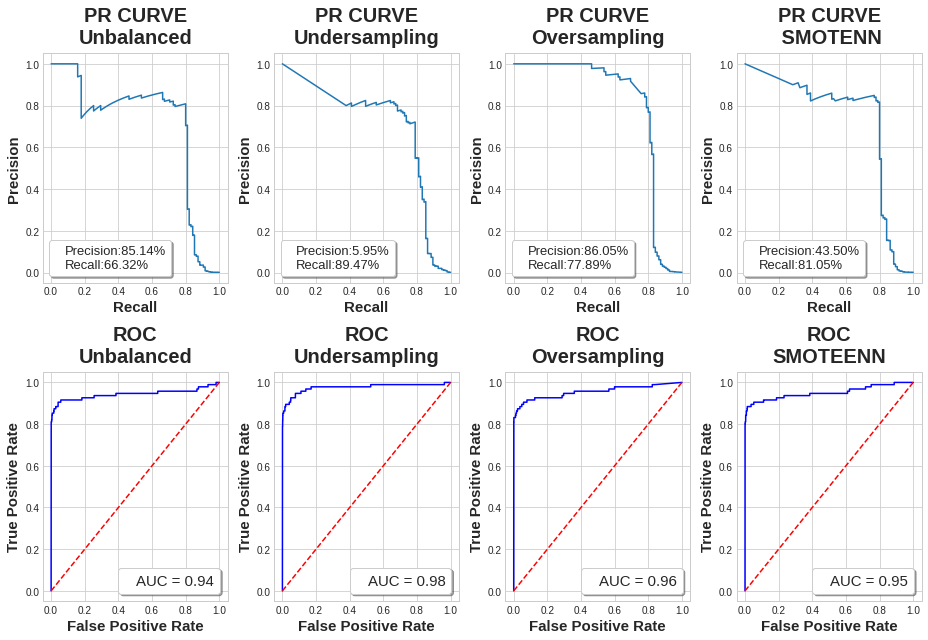

In [ ]:
fig, ax = plt.subplots(2,4,figsize=(13,9))

####PR CURVES####

p,r,_ = precision_recall_curve(y_test,y_pred_prob)
ax[0,0].plot(r,p, label = "Precision:{:.2f}%\nRecall:{:.2f}%".format(precision_score(y_test, y_pred)*100,recall_score(y_test, y_pred)*100))
ax[0,0].set_title('PR CURVE\nUnbalanced',fontsize=20)
ax[0,0].set_ylabel('Precision',fontsize=15)
ax[0,0].set_xlabel('Recall',fontsize=15)
ax[0,0].legend(loc = 'lower left', fontsize=13, fancybox=True, shadow=True, frameon=True,handlelength=0)

p,r,_ = precision_recall_curve(y_test,y_pred_prob_us)
ax[0,1].plot(r,p, label = "Precision:{:.2f}%\nRecall:{:.2f}%".format(precision_score(y_test, y_pred_us)*100,recall_score(y_test, y_pred_us)*100))
ax[0,1].set_title('PR CURVE\nUndersampling',fontsize=20)
ax[0,1].set_ylabel('Precision',fontsize=15)
ax[0,1].set_xlabel('Recall',fontsize=15)
ax[0,1].legend(loc = 'lower left', fontsize=13, fancybox=True, shadow=True, frameon=True,handlelength=0)

p,r,_ = precision_recall_curve(y_test,y_pred_prob_os)
ax[0,2].plot(r,p, label = "Precision:{:.2f}%\nRecall:{:.2f}%".format(precision_score(y_test, y_pred_os)*100,recall_score(y_test, y_pred_os)*100))
ax[0,2].set_title('PR CURVE\nOversampling',fontsize=20)
ax[0,2].set_ylabel('Precision',fontsize=15)
ax[0,2].set_xlabel('Recall',fontsize=15)
ax[0,2].legend(loc = 'lower left', fontsize=13, fancybox=True, shadow=True, frameon=True,handlelength=0)

p,r,_ = precision_recall_curve(y_test,y_pred_prob_rs)
ax[0,3].plot(r,p, label = "Precision:{:.2f}%\nRecall:{:.2f}%".format(precision_score(y_test, y_pred_rs)*100,recall_score(y_test, y_pred_rs)*100))
ax[0,3].set_title('PR CURVE\n SMOTENN',fontsize=20)
ax[0,3].set_ylabel('Precision',fontsize=15)
ax[0,3].set_xlabel('Recall',fontsize=15)
ax[0,3].legend(loc = 'lower left', fontsize=13, fancybox=True, shadow=True, frameon=True,handlelength=0)

####ROC####


fprcat, tprcat, _ = roc_curve(y_test, y_pred_prob)
roc_auccat = auc(fprcat, tprcat)
ax[1,0].plot(fprcat, tprcat, 'b', label = 'AUC = %0.2f' % roc_auccat)
ax[1,0].plot([0, 1], [0, 1],'r--')
ax[1,0].set_title('ROC\nUnbalanced',fontsize=20)
ax[1,0].set_ylabel('True Positive Rate',fontsize=15)
ax[1,0].set_xlabel('False Positive Rate',fontsize=15)
ax[1,0].legend(loc = 'lower right', fontsize=15, fancybox=True, shadow=True, frameon=True,handlelength=0)

fprcat, tprcat, _ = roc_curve(y_test, y_pred_prob_us)
roc_auccat = auc(fprcat, tprcat)
ax[1,1].plot(fprcat, tprcat, 'b', label = 'AUC = %0.2f' % roc_auccat)
ax[1,1].plot([0, 1], [0, 1],'r--')
ax[1,1].set_title('ROC\nUndersampling',fontsize=20)
ax[1,1].set_ylabel('True Positive Rate',fontsize=15)
ax[1,1].set_xlabel('False Positive Rate',fontsize=15)
ax[1,1].legend(loc = 'lower right', fontsize=15, fancybox=True, shadow=True, frameon=True,handlelength=0)


fprcat, tprcat, _ = roc_curve(y_test, y_pred_prob_os)
roc_auccat = auc(fprcat, tprcat)
ax[1,2].plot(fprcat, tprcat, 'b', label = 'AUC = %0.2f' % roc_auccat)
ax[1,2].plot([0, 1], [0, 1],'r--')
ax[1,2].set_title('ROC\nOversampling',fontsize=20)
ax[1,2].set_ylabel('True Positive Rate',fontsize=15)
ax[1,2].set_xlabel('False Positive Rate',fontsize=15)
ax[1,2].legend(loc = 'lower right', fontsize=15, fancybox=True, shadow=True, frameon=True,handlelength=0)

fprcat, tprcat, _ = roc_curve(y_test, y_pred_prob_rs)
roc_auccat = auc(fprcat, tprcat)
ax[1,3].plot(fprcat, tprcat, 'b', label = 'AUC = %0.2f' % roc_auccat)
ax[1,3].plot([0, 1], [0, 1],'r--')
ax[1,3].set_title('ROC\nSMOTEENN',fontsize=20)
ax[1,3].set_ylabel('True Positive Rate',fontsize=15)
ax[1,3].set_xlabel('False Positive Rate',fontsize=15)
ax[1,3].legend(loc = 'lower right', fontsize=15, fancybox=True, shadow=True, frameon=True,handlelength=0)



plt.tight_layout()
plt.show()

We can see that the oversampling SMOTE performed the best, with Precision=86%, Recall=78% and F1=82%.